# Esperienza Microonde

### Utility per propagazione errore

L'angolo del goniometro era sfasato, tenerne conto nella relazione

In [2]:
import sympy
import numpy as np

def value_and_covariance_gen(expr, variables):
    expr = sympy.parse_expr(expr)

    symbols = sympy.symbols(variables)
    cov_symbols = sympy.symbols(tuple("C_" + k for k in variables))
    expr2 = sum(expr.diff(s) ** 2 * c for s, c in zip(symbols, cov_symbols))
    expr2 = expr2.simplify() # recommended for speed and accuracy

    fval = sympy.lambdify(symbols, expr)
    fcov = sympy.lambdify(symbols + cov_symbols, expr2)

    def fn(**kwargs):
        x = tuple(v[0] for v in kwargs.values())
        c = tuple(v[1] for v in kwargs.values())
        return fval(*x), fcov(*x, *c)

    return fn


def value_and_covariance(expr, **kwargs):
    return value_and_covariance_gen(expr, tuple(kwargs))(**kwargs)

## Caratterizzazione del fascio

### Legge di Malus / Polarizzazione

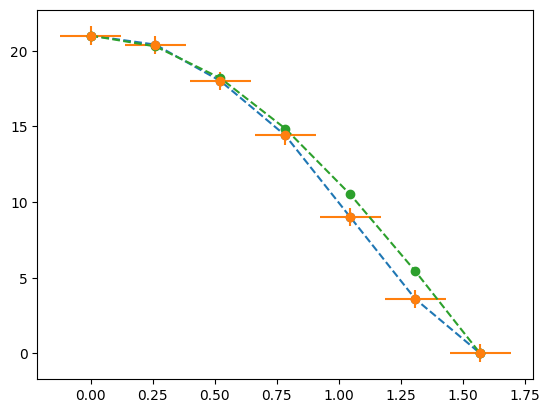

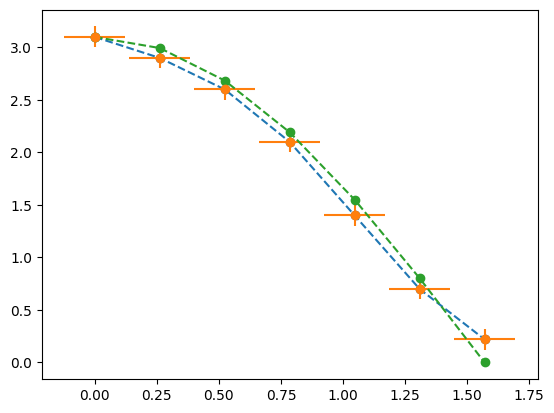

In [3]:
import numpy as np

theta = [0, 15, 30, 45, 60, 75, 90]
err_theta = 5 # gradi per un singoo ricervitore/trasmittore
err_totale = np.radians(np.sqrt(5**2+5**2))

# amperaggio mA x 30
M = [0.7, 0.68, 0.6, 0.48, 0.3, 0.12, 0] # * 30
err_M = .02 * 30
# voltmetro
V = [3.1, 2.9, 2.6, 2.1, 1.4, 0.7, 0.22]
err_V = [0.1, 0.01, 0.01, 0.01, 0.01, 0.01]

# plot data of cos(theta) with M and V
import matplotlib.pyplot as plt
plt.plot(np.radians(theta), np.array(M)*30, 'o--')
plt.errorbar(np.radians(theta), np.array(M)*30, yerr=err_M, xerr=err_totale, fmt='o')
# plot M[0]*30 * cos(theta)
plt.plot(np.radians(theta), M[0]*30 * np.cos(np.radians(theta)), 'o--')
plt.show()

# plot data of cos(theta) with V
plt.plot(np.radians(theta), V, 'o--')
plt.errorbar(np.radians(theta), V, yerr=0.1, xerr=err_totale, fmt='o')
# plot V[0] * cos(theta)
plt.plot(np.radians(theta), V[0] * np.cos(np.radians(theta)), 'o--')
plt.show()

### Ampiezza

1. Studiare dipendenza ampiezza dall'angolo
2. Studiare dipendenza ampiezza dalla distanza

<ErrorbarContainer object of 3 artists>

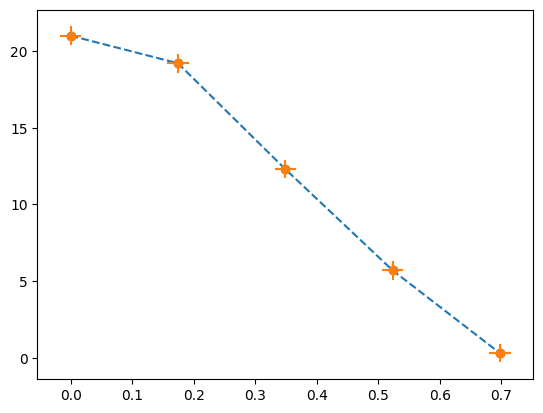

In [4]:
r_i = 101.7 # cm

# Punto 1
theta = [0, 10, 20, 30, 40]
M = [0.7, 0.64, 0.41, 0.19, 0.01] #x30

plt.plot(np.radians(theta), np.array(M)*30, 'o--')
plt.errorbar(np.radians(theta), np.array(M)*30, yerr=err_M, xerr=np.radians(1), fmt='o')



In [5]:
# confronto fit 1/r, 1/r^2
import iminuit as m
from iminuit import Minuit
from iminuit.cost import LeastSquares

# misura delle distanze fatte considerando ogni lunghezza d'onda per avere gli stessi massimi

lambda_ = 2.85 # cm

# misura amperometro
d_max = (81 - 12.5 - lambda_   * np.array([1, 2, 3, 4, 5, 6, 7, 8])) * 0.01
d_min = (81 - 12.5 - lambda_/2 * np.array([1, 3, 5, 7, 9, 11, 13, 15])) * 0.01
err_d = 0.005
M_max = np.array([0.56, 0.6, 0.64, 0.66, 0.7, 0.72, 0.76, 0.82]) * 30
M_min = np.array([0.56, 0.58, 0.6, 0.64, 0.68, 0.7, 0.72, 0.78]) * 30
err_M = 0.02 * 30
# trasform err_M in vector with 8 same vlaues
err_M = np.array([err_M] * 8)

V_max = np.array([2.4, 2.6, 2.8, 2.9, 3.1, 3.2, 3.3, 3.7])
V_min = np.array([2.4, 2.5, 2.6, 2.8, 3, 3.1, 3.2, 3.5])
err_V = 0.1

def model(x, a):
    return a/x

minimi_quadrati = LeastSquares(d_max, M_max, err_M, model)

m = Minuit(minimi_quadrati, a=1)

m.migrad()
m.hesse()
display(m)
#m.visualize()

minimi_quadrati = LeastSquares(d_min, M_min, err_M, model)

m = Minuit(minimi_quadrati, a=1)

m.migrad()
m.hesse()
display(m)
# m.visualize()

minimi_quadrati = LeastSquares(d_min, V_min, err_V, model)

m = Minuit(minimi_quadrati, a=1)

m.migrad()
m.hesse()
display(m)

minimi_quadrati = LeastSquares(d_max, V_max, err_V, model)

m = Minuit(minimi_quadrati, a=1)

m.migrad()
m.hesse()
display(m)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.678 (χ²/ndof = 0.2)      │              Nfcn = 20               │
│ EDM = 2.68e-15 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   11.24   │   0.12    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬────────┐
│   │      a │
├───┼────────┤
│ a │ 0.0134 │
└───┴────────┘

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2.084 (χ²/ndof = 0.3)      │              Nfcn = 20               │
│ EDM = 7.41e-16 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   11.10   │   0.12    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬────────┐
│   │      a │
├───┼────────┤
│ a │ 0.0141 │
└───┴────────┘

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.651 (χ²/ndof = 0.2)      │              Nfcn = 20               │
│ EDM = 2.17e-17 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   1.628   │   0.020   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬──────────┐
│   │        a │
├───┼──────────┤
│ a │ 0.000392 │
└───┴──────────┘

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3.717 (χ²/ndof = 0.5)      │              Nfcn = 20               │
│ EDM = 3.57e-16 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   1.649   │   0.019   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬──────────┐
│   │        a │
├───┼──────────┤
│ a │ 0.000371 │
└───┴──────────┘

### Geometria

In [6]:
# parliamo pure della orientazione della polarizzazione
# verticale per avere valore minimo di amperaggio

## Angolo di Brewster

In [7]:
def model(x, a):
    return a*x**2

theta = np.radians([20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 47, 57, 23, \
                    27, 33, 37, 43, 53, 63])
M = np.array([0.50, 0.52, 0.56, 0.6, 0.66, 0.67, 0.7, 0.62, 0.48, 0.42, \
              0.680, 0.6, 0.52, 0.54, 0.6, 0.62, 0.68, 0.68, 0.44]) * 30
V = np.array([2.2, 2.3, 2.5, 2.7, 2.9, 3, 3.1, 2.7, 2.1, 1.9, 3.0, 2.6, \
              2.3, 2.4, 2.6, 2.8, 3, 3, 1.9])

sorted_indices = sorted(range(len(theta)), key=lambda i: theta[i])

theta = np.array(theta)[sorted_indices]
M = M[sorted_indices]
V = V[sorted_indices]

err_M = 0.02 * 30
err_M = np.array([err_M] * len(M))

def model(x, a, b, c):
    return c + b*x + a * x**2

minimi_quadrati = LeastSquares(theta[2:16], M[2:16], err_M[2:16], model)

m = Minuit(minimi_quadrati, a=1, b=1, c=1)

m.migrad()
m.hesse()
display(m)
plt.figure()
angolo_wurstel = -m.values["b"]/(2*m.values["a"])
print(angolo_wurstel, np.degrees(angolo_wurstel))
print(m.ndof)

minimi_quadrati = LeastSquares(theta[2:16], V[2:16], 0.1, model)
m = Minuit(minimi_quadrati, a=1, b=1, c=1)
m.migrad()
m.hesse()
display(m)

angolo_wurstel = -m.values["b"]/(2*m.values["a"])
print(angolo_wurstel, np.degrees(angolo_wurstel))
print(m.ndof)



┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 12.11 (χ²/ndof = 1.1)      │              Nfcn = 84               │
│ EDM = 1.94e-16 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │    -38    │     6     │            │            │         │         │       │
│ 1 │ b    │    61     │     8     │            │            │         │         │       │
│ 2 │ c    │   -4.5    │    2.9    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬────────────────┐
│   │    a    b    c │
├───┼────────────────┤
│ a │ 34.5  -49   17 │
│ b │  -49 71.8  -25 │
│ c │   17  -25 8.53 │
└───┴────────────────┘

0.803075506740323 46.012837166550405
11.0


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 10.28 (χ²/ndof = 0.9)      │              Nfcn = 86               │
│ EDM = 2.75e-16 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   -6.1    │    1.0    │            │            │         │         │       │
│ 1 │ b    │    9.7    │    1.4    │            │            │         │         │       │
│ 2 │ c    │   -0.8    │    0.5    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────────┐
│   │     a     b     c │
├───┼───────────────────┤
│ a │ 0.965  -1.4  0.47 │
│ b │  -1.4  2.01 -0.69 │
│ c │  0.47 -0.69 0.239 │
└───┴───────────────────┘

0.7900355058587822 45.26570015119125
11.0


<Figure size 640x480 with 0 Axes>

## Interferenza

Studiare almeno due casi (per la valutazione ne vengono utilizzati due)

#### Fabry-Perot


Emettitore e ricevitore verticali

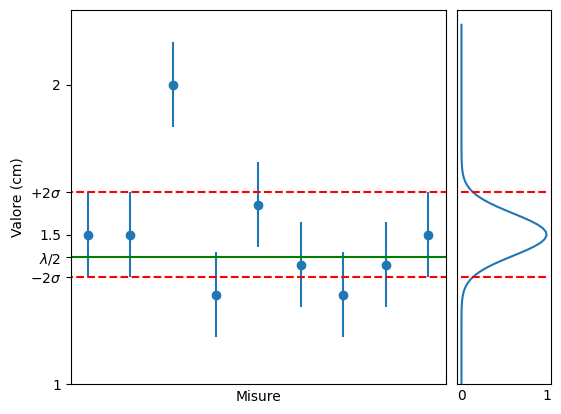

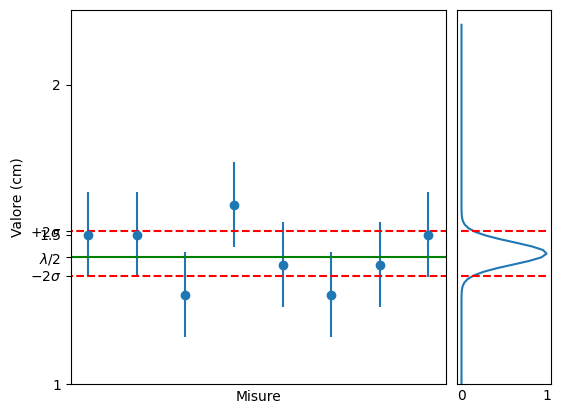

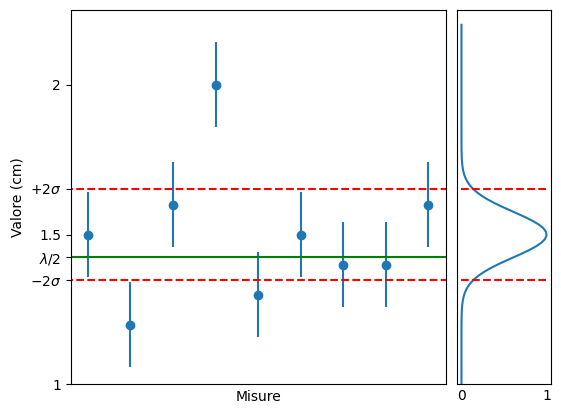

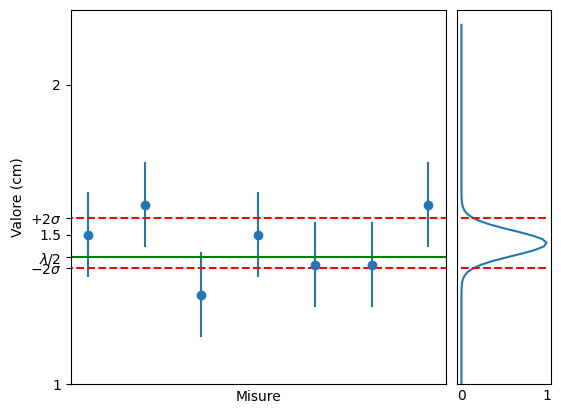

In [8]:
d_fissa = 80 #cm, non serve aumenta l'errore

#errore sistematico spessore lastre si cancella
d_min = np.array([24, 25.5, 27, 29, 30.3, 31.9, 33.3, 34.6, 36, 37.5]) #cm
d_max = np.array([23.5, 25, 26.2, 27.8, 29.8, 31.1, 32.6, 34, 35.4, 37]) #cm
err_d = 0.1 * np.sqrt(2) #cm

# create a vector difference of values between d_min[n+1] - d_min[n]
delta_d_min = np.diff(d_min)
# create a vector difference of values between d_max[n+1] - d_max[n]
delta_d_max = np.diff(d_max)

# rewrite all in a function
def plot_meas_with_gauss(delta_d, err_d, mean, std):
    fig = plt.figure(figsize=(6, 6))

    gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                        left=0.1, right=0.9, bottom=0.1, top=0.9,
                        wspace=0.05, hspace=0.05)
    
    ax = fig.add_subplot(gs[1, 0])
    ax_ploty = fig.add_subplot(gs[1, 1], sharey=ax)

    lower_bound = mean-2*std
    upper_bound = mean+2*std
 
    ax.set_xticks([])
    ax.set_xlabel("Misure")
    ax.set_ylabel("Valore (cm)")

    ax.errorbar(range(len(delta_d)), delta_d, yerr=err_d, fmt='o')
    ax.axhline(1.425,0,8, color='green')
    ax.set_yticks([1, lower_bound, 1.425, 1.5, upper_bound, 2])
    ax.set_yticklabels(["1", "$-2\\sigma$", "$\\lambda/2$", "1.5", "$+2\\sigma$", "2"])
    
    ax.axhline(lower_bound, -1, 10, color='r', linestyle="--")
    ax.axhline(upper_bound, -1, 10, color='r', linestyle="--")  
    ax.plot()

    x = np.linspace(1, 2.2, 100)
    ax_ploty.plot(np.exp(-0.5*((x-mean)/std)**2), x)
    ax_ploty.set_ylim(1, 2.25)
    ax_ploty.hlines([lower_bound, upper_bound], 0, 1, color='r', linestyles="dashed")
    ax_ploty.tick_params(labelleft=False, length=0)
    ax_ploty.plot()

mean_min = np.mean(delta_d_min)
std_min = np.std(delta_d_min, ddof=1)/np.sqrt(len(delta_d_min))
plot_meas_with_gauss(delta_d_min, err_d, mean_min, std_min)

delta_d_min = np.delete(delta_d_min, 2)
mean_min = np.mean(delta_d_min)
std_min = np.std(delta_d_min, ddof=1)/np.sqrt(len(delta_d_min))
plot_meas_with_gauss(delta_d_min, err_d, mean_min, std_min)

mean_max = np.mean(delta_d_max)
std_max = np.std(delta_d_max, ddof=1)/np.sqrt(len(delta_d_max))
plot_meas_with_gauss(delta_d_max, err_d, mean_max, std_max)

delta_d_max = np.delete(delta_d_max, 1)
delta_d_max = np.delete(delta_d_max, 2)
mean_max = np.mean(delta_d_max)
std_max = np.std(delta_d_max, ddof=1)/np.sqrt(len(delta_d_max))
plot_meas_with_gauss(delta_d_max, err_d, mean_max, std_max)

#### Doppia fenditura

Emettitore e ricevitore verticali

In [9]:
theta_min = np.radians([8, 17, 27, 40])
theta_max = np.radians([0, 13, 22, 30, ])#45])
err_theta = np.radians(1)

M_max = np.array([0.18, 0.12, 0.12, 0.1,])*30 #0.2]) * 30
M_min = np.array([0.01, 0, 0, 0]) * 30
err_M = 0.02 * 30
V_max = np.array([.8, .6, .6, .4, .8])
err_V = 0.01

d = 17 # cm
err_d = 0.2

lambda_ = 2.85 # cm

print("$\\theta_max$")
display(value_and_covariance("a * sin(t) / 2.85", a=(d, err_d), t=(theta_max, err_theta)))

print("$\\theta_min$")
display(value_and_covariance("(2 * a * sin(t) / 2.85 - 1) / 2", a =(d, err_d), t=(theta_min, err_theta)))

$\theta_max$


(array([0.        , 1.34181331, 2.23449547, 2.98245614]),
 array([0.62099126, 0.59081325, 0.53730284, 0.47189919]))

$\theta_min$


(array([0.33015534, 1.24397157, 2.20801351, 3.33417171]),
 array([0.60944012, 0.57001298, 0.49807536, 0.37458625]))

## Diffrazione di Bragg

In [10]:
# primo tentativo, massimo con n stimato = 2
thetas = np.radians([39, 40, 41, 42, 43, 44]) #tentativo 2 con offset basso
M = [0.12, 0.24, 0.16, 0.5, 0.34, 0.34 ] #x1 milliA
err_M = np.array([0.02] * len(M))

# secondo tentativo, massimo con n stimato = 1
thetas2 = np.radians([21, 22, 23, 24, 26])
M2 = [0.3, 0.38*3, 0.38*3, 0.8*3, 0.14] 
err_M2 = np.array([0.1, 0.3, 0.3, 0.3, 0.1])

In [11]:
# fit del primo tentativo

def model(x, a, b, c):
    return c + b*x + a  *x**2

minimi_quadrati = LeastSquares(thetas, M, err_M, model)
m = Minuit(minimi_quadrati, a=1, b=1, c=1)

m.migrad()
m.hesse()
display(m)
plt.figure()

theta_max = value_and_covariance("-b/ (2*a)", b=(m.values["b"], m.errors["b"]), a =(m.values["a"], m.errors["a"]))
print(theta_max)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 109.5 (χ²/ndof = 36.5)     │              Nfcn = 87               │
│ EDM = 4.95e-12 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │    -54    │    11     │            │            │         │         │       │
│ 1 │ b    │    81     │    16     │            │            │         │         │       │
│ 2 │ c    │    -30    │     6     │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────────┐
│   │       a       b       c │
├───┼─────────────────────────┤
│ a │     119 -0.17e3      62 │
│ b │ -0.17e3     249     -90 │
│ c │      62     -90    32.6 │
└───┴─────────────────────────┘

(0.7507192286029651, 0.0034652400795319106)


<Figure size 640x480 with 0 Axes>

In [12]:
# fit per tentativo due

def model(x, a, b, c):
    return c + b*x + a  *x**2

minimi_quadrati = LeastSquares(thetas2, M2, err_M2, model)
m = Minuit(minimi_quadrati, a=1, b=1, c=1)

m.migrad()
m.hesse()
display(m)
plt.figure()

theta_max2 = value_and_covariance("-b/ (2*a)", b=(m.values["b"], m.errors["b"]), a =(m.values["a"], m.errors["a"]))
print(theta_max2)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 9.44 (χ²/ndof = 4.7)       │              Nfcn = 92               │
│ EDM = 2.93e-13 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │  -0.83e3  │  0.11e3   │            │            │         │         │       │
│ 1 │ b    │    680    │    90     │            │            │         │         │       │
│ 2 │ c    │   -137    │    19     │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬────────────────────────────┐
│   │        a        b        c │
├───┼────────────────────────────┤
│ a │ 1.29e+04    -11e3    2.2e3 │
│ b │    -11e3  8.7e+03   -1.8e3 │
│ c │    2.2e3   -1.8e3      359 │
└───┴────────────────────────────┘

(0.409298155587666, 6.190347325987653e-05)


<Figure size 640x480 with 0 Axes>

In [13]:
# calcolo di d con fit

n = np.array([2,1]) #tentativo 1 ha n=2, tentativo 2 ha n=1
thetas_max = np.array([theta_max[0], theta_max2[0]])
err_thetas_max = np.array([theta_max[1], theta_max2[1]])

def model(x, d):
    return np.arcsin((x * lambda_)/(2*d))

minimi_quadrati = LeastSquares(n, thetas_max, err_thetas_max, model)
m = Minuit(minimi_quadrati, d=3.8)

m.migrad()
m.hesse()
display(m)
plt.figure()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2395 (χ²/ndof = 2394.8)    │              Nfcn = 28               │
│ EDM = 2.52e-08 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ d    │  3.5821   │  0.0005   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬──────────┐
│   │        d │
├───┼──────────┤
│ d │ 2.61e-07 │
└───┴──────────┘

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [14]:
# calcolo di d con media pesata

d1 = value_and_covariance("(2 * 2.85) / (2 * sin(t) )", t = (theta_max[0], theta_max[1]))
d2 = value_and_covariance("(1 * 2.85) / (2 * sin(t) )", t = (theta_max2[0], theta_max2[1]))
print(d1)
print(d2)

d_val = np.array(d1[0], d2[0])
d_err = np.array(d1[1], d2[1])

def weighet_mean(vec_x, err_vec_x):
    return np.sum(vec_x/err_vec_x**2) / np.sum(1/err_vec_x**2), 1/np.sqrt(np.sum(1/err_vec_x**2))

#d = weighet_mean(d_val, d_err)
#print(d)

d = (d1[0]/(d1[1]**2) + d2[0]/(d2[1]**2))/((1/d1[1])**2 + (1/d2[1])**2)
print(d)

(4.177875863395033, 0.06949222720212653)
(3.5807119149289024, 0.004217747969098461)
3.5829036370009817


### Scansionamento totale 

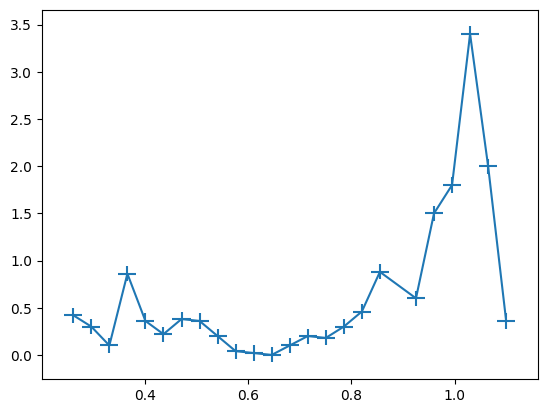

In [15]:
# scan totale per cercare i massimi

theta = np.array(np.radians([15,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47,49,53,55,57,59,61,63]))
M = np.array([0.42, 0.3, 0.1, 0.86, 0.36, 0.22, 0.38, 0.36, 0.2, \
            0.04, 0.02, 0, 0.1, 0.2, 0.18, 0.3, 0.46, 0.88, 0.60, 1.5, 1.8, 3.4, 2.0, 0.36])
err_theta = np.radians(1)
err_M = np.array([0.08] * len(M))

plt.errorbar(theta, M, err_M, err_theta)
plt.show()

In [16]:
# tentativo 3 intorno a massimo trovato con scan totale

thetas3 = np.array(np.radians([57, 58, 59, 60, 61, 62, 63, 64]))
M3 = np.array([1.8, 2.64, 3.4, 2.04, 2.0,  0.2, 0.36, 0.14]) 
err_M3 = np.array([0.24] * len(M3))

def model(x, a, b, c):
    return c + b*x + a  *x**2

minimi_quadrati = LeastSquares(thetas3, M3, err_M3, model)
m = Minuit(minimi_quadrati, a=1, b=1, c=1)

m.migrad()
m.hesse()
display(m)
plt.figure()

theta_max3 = value_and_covariance("-b/ (2*a)", b=(m.values["b"], m.errors["b"]), a =(m.values["a"], m.errors["a"]))
print(theta_max3)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 47.77 (χ²/ndof = 9.6)      │              Nfcn = 72               │
│ EDM = 2.46e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   -280    │    40     │            │            │         │         │       │
│ 1 │ b    │    570    │    80     │            │            │         │         │       │
│ 2 │ c    │   -290    │    40     │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬────────────────────────────┐
│   │        a        b        c │
├───┼────────────────────────────┤
│ a │ 1.52e+03   -3.2e3    1.7e3 │
│ b │   -3.2e3 6.78e+03   -3.6e3 │
│ c │    1.7e3   -3.6e3 1.89e+03 │
└───┴────────────────────────────┘

(1.0163270731284735, 0.0007689116910559404)


<Figure size 640x480 with 0 Axes>

In [32]:
# calcolo di d da terzo tentativo

d3 = value_and_covariance("(2 * 2.85) / (2 * sin(t) )", t = (theta_max3[0], theta_max3[1]))
print(d3)

(3.3522313167365807, 0.0033136486017470794)


In [33]:
# calcolo di d con fit con gli effettivi massimi

n = np.array([1,2])
thetas_max = np.array([theta_max2[0], theta_max3[0]])
err_thetas_max = np.array([theta_max2[1], theta_max3[1]])

def model(x, d):
    return np.arcsin((x * lambda_)/(2*d))

minimi_quadrati = LeastSquares(n, thetas_max, err_thetas_max, model)
m = Minuit(minimi_quadrati, d=3.8)

m.migrad()
m.hesse()
display(m)
plt.figure()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.464e+04 (χ²/ndof = 14640.4)│              Nfcn = 28               │
│ EDM = 3.51e-08 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ d    │  3.5660   │  0.0005   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬──────────┐
│   │        d │
├───┼──────────┤
│ d │ 2.43e-07 │
└───┴──────────┘

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [34]:
# calcolo d con media pesata e massimi effettivi

d = (d2[0]/(d2[1]**2) + d3[0]/(d3[1]**2))/((1/d2[1])**2 + (1/d3[1])**2)
print(d)

3.439433513439069


## Unione di tutte le misure

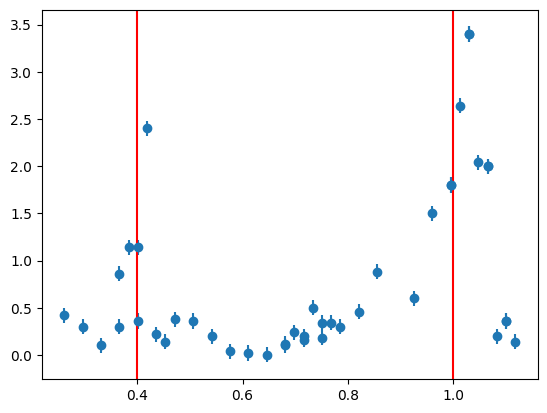

In [27]:
theta = np.array(np.radians([39, 40, 41, 42, 43, 44, 21, 22, 23, 24, 26, 15,17,19,21,23,25,27,29, \
                             31,33,35,37,39,41,43,45,47,49,53,55,57,59,61,63, 57, 58, 59, 60, 61, 62, 63, 64]))

M = np.array([0.12, 0.24, 0.16, 0.5, 0.34, 0.34, 0.3, 0.38*3, 0.38*3, 0.8*3, 0.14, 0.42, 0.3, 0.1, 0.86, 0.36, 0.22, 0.38, 0.36, 0.2, \
            0.04, 0.02, 0, 0.1, 0.2, 0.18, 0.3, 0.46, 0.88, 0.60, 1.5, 1.8, 3.4, 2.0, 0.36, \
            1.8, 2.64, 3.4, 2.04, 2.0,  0.2, 0.36, 0.14])

err_M = np.array( [0.08] * len(M) )

plt.errorbar(theta, M, err_M, fmt='o')
plt.axvline(0.4,0,1,color='r')
plt.axvline(1,0,1,color='r')
plt.show()